In [ ]:
from scipy.sparse import csr_matrix, hstack, vstack, kron, eye, block_diag
from typing import Tuple

def repetition_code(distance: int) -> csr_matrix:
    row_ind, col_ind = zip(
        *((i, j) for i in range(distance) for j in (i, (i + 1) % distance))
    )
    data = np.ones(2 * distance, dtype=np.uint8)
    return csr_matrix((data, (row_ind, col_ind)))


def toric_code_matrices(
    distance: int,
) -> Tuple[csr_matrix, csr_matrix, csr_matrix, csr_matrix]:
    """Check matrices of a toric code on an unrotated lattice"""
    H = repetition_code(distance=distance)
    # print(f"Toric code distance: {distance}")
    # print(f"Stabilizer matrix H:\n{H.toarray()}")
    assert H.shape[1] == H.shape[0] == distance
    e = eye(distance)

    Hx = csr_matrix(hstack([kron(H, e), kron(e, H.T)], dtype=np.uint8))
    Hz = csr_matrix(hstack([kron(e, H), kron(H.T, e)], dtype=np.uint8))

    L0 = csr_matrix(([1], ([0], [0])), shape=(1, distance), dtype=np.uint8)
    L1 = csr_matrix(np.ones((1, distance), dtype=np.uint8))

    Lx = csr_matrix(block_diag([kron(L0, L1), kron(L1, L0)])) # logical operators (X) - first line of vertical, horizontal - anti-commute with Hz - lines across lattice
    Lz = csr_matrix(block_diag([kron(L1, L0), kron(L0, L1)])) # logical operators (Z) - first line of horizontal, vertical - anti-commute with Hx - lines on the edge of the lattice

    for m in (Hx, Hz, Lx, Lz):
        m.data = m.data % 2
        m.sort_indices()
        m.eliminate_zeros()

    return Hx, Hz, Lx, Lz

# if __name__ == "__main__":
#     import numpy as np

#     distance = 4  # Example distance
#     Hx, Hz, Lx, Lz = toric_code_matrices(distance)
    
#     print(f"Hx:\n{Hx.toarray()}")
#     print(f"Hz:\n{Hz.toarray()}")
#     print(f"Lx:\n{Lx.toarray()}")
#     print(f"Lz:\n{Lz.toarray()}")

In [ ]:
import time

from ldpc.bp_decoder import BpDecoder
from ldpc.bposd_decoder import BpOsdDecoder
import numpy as np
import matplotlib.pyplot as plt

def generate_bsc_error(n: int, error_rate: float) -> np.ndarray:
    """
    Generate a binary symmetric channel (BSC) errors.
    
    Parameters:
        n (int): The length of the array to generate.
        error_rate (float): The probability of a bit being flipped (0 <= error_rate <= 1)

    Returns:
        np.ndarray: An array of size n with 0s and 1s, where 1 indicates an error.
    
    Example:
        >>> generate_bsc_error(10, 0.1)
        array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0])
    """
    return np.random.binomial(1, error_rate, size=n).astype(np.uint8)

def compute_logical_error_rate(H, L, error_rate, run_count, DECODER, run_label, DEBUG=False):
    """Calculate logical error rate for a given decoder."""
    
    fail = 0

    start_time = time.time()

    failed_runs_not_bp = []

    for i in range(run_count):
        error = generate_bsc_error(H.shape[1], error_rate)
        syndrome = (H @ error) % 2
        decoding = DECODER.decode(syndrome)
        residual = (decoding + error) % 2

        if isinstance(DECODER, BpDecoder):
            if not DECODER.converge:
                fail += 1
                continue
        
        if np.any(L @ residual) % 2:
            fail += 1
            if isinstance(DECODER, BpOsdDecoder):
                failed_runs_not_bp.append(i)
            if DEBUG:
                print(f"Failed run: {i}")
                print(f"Syndrome: {np.nonzero(syndrome)[0].__repr__()}")
            
    end_time = time.time()
    runtime = end_time - start_time
    logical_error_rate = fail / run_count
    print(f"Decoder {run_label} finished in {runtime:.2f} seconds with {fail} failures out of {run_count} runs.")
    print(f"Logical error rate for {run_label}: {logical_error_rate:.4f}")

    return logical_error_rate

# compare between BP and BP+OSD decoders with different distances of the toric code

distances = [9, 11, 13, 15]
error_rates = np.linspace(0.01, 0.15, 15)  # Error rates from 0.01 to 0.15
max_iter = 10
ms_scaling_factor = 0.625
osd_order = 60  # Order of the OSD method
run_count = 10000 # Number of runs for each error rate
logical_error_rates_bp = []
logical_error_rates_bp_osd = []

for d in distances:
    print(f"Distance: {d}")
    logical_error_rates_bp_with_d = []
    logical_error_rates_bp_osd_with_d = []
    Hx, Hz, Lx, Lz = toric_code_matrices(d)
    # remove the last row of Hx and Hz
    Hx = Hx[:-1, :]
    Hz = Hz[:-1, :]
    # H = vstack([Hx, Hz])

    for p in error_rates:
        # Initialize the BP decoder
        bp_decoder = BpDecoder(
        pcm=Hz,
        error_rate=float(p),
        max_iter=max_iter,
        ms_scaling_factor=ms_scaling_factor,
        schedule='parallel',
        )

        logical_error_rate_bp = compute_logical_error_rate(
            Hz, Lx, p, run_count=run_count, DECODER=bp_decoder, run_label=f"BP (d={d}, p={p})"
        )
        logical_error_rates_bp_with_d.append(logical_error_rate_bp)

        bp_osd_decoder = BpOsdDecoder(
            pcm=Hz,
            error_rate=float(p),
            max_iter=max_iter,
            ms_scaling_factor=ms_scaling_factor,
            schedule='parallel',
            osd_method='OSD_CS',
            osd_order=osd_order,
        )
        logical_error_rate_bp_osd = compute_logical_error_rate(
            Hz, Lx, p, run_count=run_count, DECODER=bp_osd_decoder, run_label=f"BP+OSD (d={d}, p={p})"
        )
        logical_error_rates_bp_osd_with_d.append(logical_error_rate_bp_osd)
    
    logical_error_rates_bp.append(logical_error_rates_bp_with_d)
    logical_error_rates_bp_osd.append(logical_error_rates_bp_osd_with_d)

    # bp_osd_decoder = BpOsdDecoder(Hx, Hz, Lx, Lz)



Distance: 9
Decoder BP (d=9, p=0.01) finished in 0.63 seconds with 447 failures out of 10000 runs.
Logical error rate for BP (d=9, p=0.01): 0.0447
Decoder BP+OSD (d=9, p=0.01) finished in 1.48 seconds with 99 failures out of 10000 runs.
Logical error rate for BP+OSD (d=9, p=0.01): 0.0099
Decoder BP (d=9, p=0.019999999999999997) finished in 0.76 seconds with 1647 failures out of 10000 runs.
Logical error rate for BP (d=9, p=0.019999999999999997): 0.1647
Decoder BP+OSD (d=9, p=0.019999999999999997) finished in 3.94 seconds with 371 failures out of 10000 runs.
Logical error rate for BP+OSD (d=9, p=0.019999999999999997): 0.0371
Decoder BP (d=9, p=0.03) finished in 0.97 seconds with 3197 failures out of 10000 runs.
Logical error rate for BP (d=9, p=0.03): 0.3197
Decoder BP+OSD (d=9, p=0.03) finished in 6.93 seconds with 817 failures out of 10000 runs.
Logical error rate for BP+OSD (d=9, p=0.03): 0.0817
Decoder BP (d=9, p=0.039999999999999994) finished in 1.11 seconds with 4493 failures out 

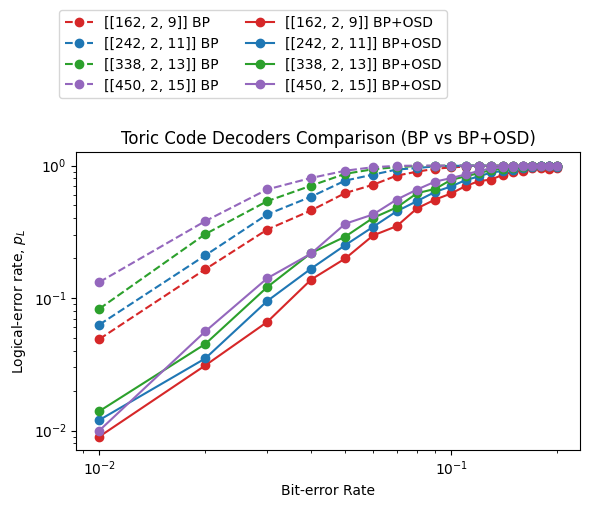

In [124]:
colors = {
    9: 'tab:red',
    11: 'tab:blue',
    13: 'tab:green',
    15: 'tab:purple'
}

plt.figure(figsize=(6, 6))
plt.title("Toric Code Decoders Comparison (BP vs BP+OSD)")
plt.xlabel("Bit-error Rate")
plt.ylabel(r"Logical-error rate, $p_L$")
plt.xscale('log')
plt.yscale('log')

# Use different loop variables to avoid overwriting
for d, bp_vals in zip(distances, logical_error_rates_bp):
    plt.plot(
        error_rates, bp_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP",
        marker='o',
        linestyle='--',
        color=colors[d]
    )

for d, bp_osd_vals in zip(distances, logical_error_rates_bp_osd):
    plt.plot(
        error_rates, bp_osd_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP+OSD",
        marker='o',
        linestyle='-',
        color=colors[d]
    )

plt.legend(bbox_to_anchor=(0.75, 1.5), ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

colors = {
    9: 'tab:red',
    11: 'tab:blue',
    13: 'tab:green',
    15: 'tab:purple'
}

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Toric Code Decoders Comparison (BP vs BP+OSD)")
ax.set_xlabel("Bit-error Rate")
ax.set_ylabel(r"Logical-error rate, $p_L$")
ax.set_xscale('log')
ax.set_yscale('log')

for d, bp_vals in zip(distances, logical_error_rates_bp):
    ax.plot(
        error_rates, bp_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP",
        marker='o',
        linestyle='--',
        color=colors[d]
    )

for d, bp_osd_vals in zip(distances, logical_error_rates_bp_osd):
    ax.plot(
        error_rates, bp_osd_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP+OSD",
        marker='o',
        linestyle='-',
        color=colors[d]
    )

# Add zoomed inset
axins = inset_axes(ax, width="45%", height="45%", loc='lower left', borderpad=2)
axins.set_xlim(0.088, 0.105)  # Adjust x-limits to zoom into threshold
axins.set_ylim(0.12, 0.3)     # Adjust y-limits to match threshold region
axins.set_xticks([0.09, 0.10])
axins.set_yticks([0.15, 0.25])

for d, bp_vals in zip(distances, logical_error_rates_bp):
    axins.plot(error_rates, bp_vals, marker='o', linestyle='--', color=colors[d])

for d, bp_osd_vals in zip(distances, logical_error_rates_bp_osd):
    axins.plot(error_rates, bp_osd_vals, marker='o', linestyle='-', color=colors[d])

# Add rectangle connector lines between main plot and inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Add label to inset
axins.text(0.089, 0.29, "Threshold zoom", fontsize=8)

ax.legend(bbox_to_anchor=(0.75, 1.5), ncol=2)
fig.tight_layout()
plt.show()
